# In this notebook I will:
* Go through and remove reviews that only have advertisements? (NOT AT THIS TIME)
* Tokenize, lemmatize, remove stop words, and remove instances of words that only show up once that aren't special (words that indicate a condition, medication, side effect, or caregiver role)
* Rejoin processed review into a string for BOW analysis

In [1]:
import pandas as pd
import numpy as np
import glob

# Haven't decided whether I like nltk or spacy better yet
import nltk
from nltk.corpus import wordnet#, stopwords
#stops = stopwords.words('english')
import spacy
from spacy.tokenizer import Tokenizer
import en_core_web_lg
nlp = en_core_web_lg.load()

# Magical gensim module
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# A method to process text in nltk:
# https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

# same process in spacy
# https://spacy.io/usage/linguistic-features

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# https://stackoverflow.com/questions/13928155/spell-checker-for-python/48280566
from autocorrect import Speller
spell = Speller(lang='en')

In [5]:
# Adjusting stop words in spacy to not lose a bunch of negatives for the sentiment analysis
# for word in [u'nor',u'none',u'not',u'alone',u'no',u'never',u'cannot',u'always']:
#     nlp.vocab[word].is_stop = False
# nlp.vocab[u'thing'].is_stop = True


# Working on processing text data

In [6]:
def get_wordnet_pos(treebank_tag):
    # https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
#     elif treebank_tag.startswith('NN'):
#         return wordnet.ADJ # Considering ADJ_SET to be same as ADJ
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def check_PoS(word):
    return get_wordnet_pos(nltk.pos_tag([word])[0][1])

def useful_synonyms(word):
    # Finding PoS of word
    to_pos = check_PoS(word)
    
    # Finding all synonyms in all the parts of speech
    words = []
    syns = wordnet.synsets(word)

    # Chopping down to most common versions of words...this works for side effects more than words like 'cat'
    if len(syns) >= 2:
        synList = syns[:2]
    else:
        synList = syns
    #     if len(syns)%2 and (len(syns) != 1):
#         synList = syns[:len(syns)//2]
#     else:
#         synList = syns[:len(syns)//2+1]

    # Finding all the forms of a word
    for syn in synList:
        for l in syn.lemmas():
            form = l.derivationally_related_forms()
            words.append(l.name())
            for f in form:
                words.append(f.name())
                
    # Getting all the unique words that match the desired part of speech
    words = list(np.unique(words))
    pos = nltk.pos_tag(words)
    return_words = [word.replace('_',' ') for word, word_pos in pos if get_wordnet_pos(word_pos)==to_pos]

    # Getting around weirdness with somehow dropping PoS for original word if matches to_pos (e.g., with weight)
    if get_wordnet_pos(nltk.pos_tag([word])[0][1]) == to_pos and word not in return_words: return_words.append(word)
        
    return return_words

In [7]:
# Magic tokenizer thing
def spacyTokenizer(s: str)-> list:
    doc = tokenizer(s.lower().strip())
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':
            tokens.append(token.lemma_)
        
    return tokens

In [73]:
def parseRevnew(file, return_df=False):
    reviews = pd.read_csv(file, sep='$')['Comment']
    clean_reviews = [spacyTokenizer(rev.replace('/', ' ')) for rev in reviews]
    cleaner_reviews = findTop(clean_reviews, 50)
    cleaner_reviews = [[spell(word.lower()) for word in rev] for rev in cleaner_reviews]
    
    if return_df:
        return cleaner_reviews, reviews
    else:
        return cleaner_reviews#consider, ignore

def parseSEorig(file):
    sideEff = np.genfromtxt(file, delimiter='$', dtype=str)
    clean_SEs = [[spell(word) for word in spacyTokenizer(SE)] for SE in sideEff]
    cleaner_reviews = findTop(clean_SEs, 3)
    
    return clean_SEs
    
def parseSE_FAERs(file, meds):
    sideEff = pd.read_csv(file, sep='$').set_index('Concept ID').dropna(subset=['Percentage observed'])
    sideEff = sideEff.fillna(value='')

    # Looking for the medication name that has the side effects
    meds_obs = sideEff.copy(deep=True)
    meds_obs['Medications observed'] = [obs.split(', ') for obs in meds_obs['Medications observed']]
    
    medList = []
    for obs in meds_obs['Medications observed']: medList += obs
        
    to_check = np.unique(medList)
    
    Found = False
    for med in meds.lower().split(', '):
        if med in to_check: 
            Found = True
            break # Stop when I've found the name

    sideEff = sideEff[[med in obs for obs in meds_obs['Medications observed']]]
    
    sideEff['Joined'] = sideEff['Definition'] + sideEff['Synonyms']
    check_both = lambda combo: sum([c in nlp.vocab for c in combo.split(' ')]) == len(combo.split(' '))
    sideEff['Joined'] = [', '.join([word for word in words.split(', ') if word.find('-') == -1 and check_both(word)]) for words in sideEff['Joined']]
    clean_SEs = [list(set([spell(word) for word in spacyTokenizer(SE)])) for SE in sideEff['Joined']]
    clean_SEs = [[word for word in SE if len(word) > 3] for SE in clean_SEs]
    clean_SEs = findTop(clean_SEs,5)
    
#     ignore = [SE for SE in clean_SEs if len(SE) <= 2]
#     consider = [SE for SE in clean_SEs if len(SE) > 2]
    
#     # Testing effect of just adding in more language to work with
#     new_consider = []
#     for chunk in consider:
#         extended = []
#         for w in chunk:
#             extended += [s for s in useful_synonyms(w) if s.find('_') == -1]
#         new_consider.append(extended)
    
    return clean_SEs#consider, ignore

# TFIDF section
https://buhrmann.github.io/tfidf-analysis.html

In [25]:
# Not super useful to take the mean across columns, instead look at top 10 scoring words in each side effect
def findTop(strList, keeptop=10):
    tfidf_vectr = TfidfVectorizer()
    corpus = [' '.join(SE) for SE in strList]
    tfidf_score = tfidf_vectr.fit_transform(corpus).toarray()
    features = np.array(tfidf_vectr.get_feature_names())
    
    words = []
    for row in tfidf_score:
        inds = row.argsort()[::-1][:keeptop]
        row_words = []
        for ind in inds:
            if row[ind].round(2) != 0:
                row_words.append(features[ind])
                #print(features[ind],' '*(50-len(features[ind])), row[ind].round(2))
        #print('\n')
        if not row_words:
            row_words = list(features[inds][:5])
        words.append(row_words)
    return words

# LSA/LDA section

In [26]:
# https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
def genDictandDocMatrix(cleaned_text):
    dictionary = corpora.Dictionary(cleaned_text)
    matrix = [dictionary.doc2bow(doc) for doc in cleaned_text]
    return dictionary, matrix

def formatLSAresult(topics:list)->list:
    for topic in topics:
        title = "Topic {:g}: \n".format(topic[0])
        term_cluster = [term.strip().split('*')[1][1:-1] for term in topic[1].split('+')]
        term_weight = [term.strip().split('*')[0] for term in topic[1].split('+')]

        print(title, ', '.join(term_cluster),'\n',', '.join(term_weight))
        
def produceLSA(n_topics, cleanText, n_word_report=10):
    dictionary, matrix = genDictandDocMatrix(cleanText)
    lsamodel = LsiModel(matrix, num_topics=n_topics, id2word=dictionary)
    result = lsamodel.print_topics(num_topics=n_topics, num_words=n_word_report)

    return result, lsamodel

def produceLDA(n_topics, cleanText, n_word_report=10):
    dictionary, matrix = genDictandDocMatrix(cleanText)
    ldamodel = LdaModel(matrix, num_topics=n_topics, id2word=dictionary)
    result = ldamodel.print_topics(num_topics=n_topics, num_words=n_word_report)

    return result, ldamodel

#result, model = produceLSA(10, reviews)
#formatLSAresult(result)

In [27]:
# Testing out idea of randomly joining side effects and pulling out concepts
from random import shuffle

#test = cleanSEs.copy()

# Joining test results randomly
def try_shuffled_LSA(test, numjoin=5):
    joined_test = []
    inds = np.arange(len(test))
    shuffle(inds)

    if inds.size % numjoin:
        extras = inds[-(inds.size % numjoin):]
        evendiv = inds[:-(inds.size % numjoin)]
        inds = evendiv.reshape((-1,numjoin))
    else:
        extras = None
        inds = inds.reshape((-1,numjoin))


    for ind_set in inds:
        new_join = []
        for ind in ind_set: new_join += test[ind]
        joined_test.append(new_join)

    if type(extras) != type(None):
        for i,ind in enumerate(extras):
            joined_test[i] += test[ind]

    result, model = produceLDA(len(test)//5, joined_test, 10)
    formatLSAresult(result)
#     topics = {}
#      for topic in result:
#         title = "Topic {:g}: \n".format(topic[0])
#         term_cluster = [term.strip().split('*')[1][1:-1] for term in topic[1].split('+')]
#         term_weight = [term.strip().split('*')[0] for term in topic[1].split('+')]
        
#         topics[topic[0]] = term_cluster
        
#     return topics
    
    
def process_shuffled_results(topic_dict_list):
    for topics_dict in topic_dict_list:
        word_pile = []
        for key in topics_dict:
            word_pile.append(topics_dict[key])
        word_pile = np.array(word_pile)

In [28]:
#try_shuffled_LSA(test)

# Writing some code to perform sentiment analysis on the full reviews

In [132]:
from nltk.sentiment import vader
VADER_SIA = vader.SentimentIntensityAnalyzer()

def find_polarity_scores(reviews):
    VADERscorePos = []
    VADERscoreNeg = []
    for rev in reviews:
        VADERscorePos.append(VADER_SIA.polarity_scores(rev)['pos'])    
        VADERscoreNeg.append(VADER_SIA.polarity_scores(rev)['neg'])            
        
    return VADERscorePos, VADERscoreNeg

# Now checking for side effects in WebMD reviews

In [144]:
def find_sideEffects_inReviews_FAERsinformed(revFile, sefile1, sefile2, faers=True):

    # Parsing reviews
    reviews, fullrevs = parseRevnew(revFile, return_df=True)
    if faers:
        cond = sefile1[sefile1.find('faers_results/')+14:sefile1.rfind('/')]
        medication = revFile[revFile.rfind('/')+1:revFile.find('_'+cond)]
        meds = pd.read_csv('UniqueMedications/Medications_unique_{:s}.csv'.format(cond), sep='$')['All names']
        meds = [allnames for allnames in meds if medication.lower() in allnames.lower().split(', ')][0]

    # Parsing side effects
    if faers:
        listSEs = parseSE_FAERs(sefile1, meds)
    else:
        listSEs = parseSEorig(sefile2)
        
    #new attempt
    listSEs1 = parseSE_FAERs(sefile1, meds)
    listSEs2 = parseSEorig(sefile2)
    listSEs = listSEs1 + listSEs2
    
    BagOSE = ' '.join([' '.join(SE) for SE in listSEs])

    # Finding review words that exist in the list of side effects
    # Only requiring space at the beginning because of words like nausea-nauseated, etc.
    found = [[word for word in rev if BagOSE.lower().find(' '+word.lower())] for rev in reviews]
    found = []
    for ind, rev in enumerate(reviews):
        item = {}
        for SE in listSEs:
            # Match words in reviews to side effects and then add them to found, build dataframe with this info
            item[', '.join(SE)] = len([word for word in rev if word.lower() in SE])
        found.append(item)
    
    SE_match = pd.DataFrame(found)
    SE_match['Full Review'] = fullrevs.values
    
    # Return the master product
    return SE_match

In [159]:
df = find_sideEffects_inReviews_FAERsinformed('ProcessedReviews/Bipolar-Disorder/Lamictal_Bipolar-Disorder_parsed_reviews.csv', 
                                              'NERstuff/faers_results/Bipolar-Disorder/SideEffectsExtracted.csv',
                                              'SideEffects/Bipolar-Disorder_SideEffects.csv')

In [160]:
pos, neg = find_polarity_scores(df['Full Review'])
df['Positive polarity'] = pos
df['Negative polarity'] = neg

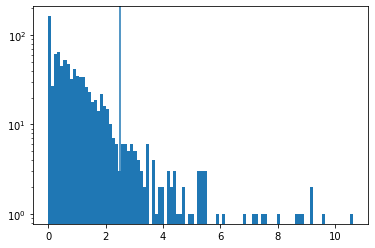

In [161]:
cond = (df['Negative polarity'] != 0)
plt.hist(np.array(df['Positive polarity'][cond]/df['Negative polarity'][cond]), bins=100)
plt.axvline(2.5)
plt.yscale('log')

diff_inds = df.index[cond][(df['Positive polarity'][cond]/df['Negative polarity'][cond] > 2.5)]

In [162]:
newdf = df.drop(columns=['Full Review', 'Positive polarity', 'Negative polarity'])
review_inds = []




In [ ]:
def screen_for_hits(df):
    newdf = df.drop(columns=['Full Review', 'Positive polarity', 'Negative polarity'])
    review_inds = []
    
    # Allowing for two item side effects UNLESS they contain very generic words
    colLens = np.array([len(col.split(', ')) + 2*((col.find('skin')!=-1)|
                                                  (col.find('feel') != -1)|
                                                  (col.find('pain')!= -1)|
                                                  (col.find('abnormal')!=-1)|
                                                  (col.find('change')!=-1)|
                                                  (col.find('disorder')!=-1)|
                                                  (col.find('problem')!=-1)|
                                                  (col.find('decrease')!=-1)|
                                                  (col.find('increase')!=-1)|
                                                  (col.find('loss')!=-1)) for col in newdf.columns])
    
    # If the column is not generic and has two or fewer words, count one word as a match, otherwise require 2
    for ind in newdf.index:
        if (((colLens < 3) & newdf.loc[ind].gt(0)) | newdf.loc[ind].gt(1)).sum(): 
            review_inds.append(ind)
            
    # Screening based on polarity
    cond = (df['Negative polarity'] != 0)
    diff_inds = df.index[cond][(df['Positive polarity'][cond]/df['Negative polarity'][cond] > 2.5)]
    
    # Marking hits versus not
    found_reviews = []
    for ind in review_inds:
        conditions = np.logical_or(np.logical_and((colLens < 3), newdf.loc[ind].gt(0)), newdf.loc[ind].gt(1))
        newdf.loc[ind][conditions] = 1
        newdf.loc[ind][not conditions] = 0
        found_reviews.append(sum(conditions))
    
    # Creating one big dataframe
    toconcat = df.drop(columns=[col for col in df.columns if col not in ['Full Review', 'Positive polarity', 'Negative polarity']])
    master_df = pd.concat([toconcat, newdf], axis=1)
    
    # Not dropping rows with no hits because that is also important infomration
    return master_df

# Side effects match so now...
* Only keep reviews that have side effects
* Think on how to deal with meds with lower review counts
* Process reviews medications with one hot encode
* Perform sentiment analysis on each raw comment
* Only count SEs if positive to negative sentiment is below some threshold
* Add sentiments and encoded medications to the side effect DF, stack for each medication, and save